## Create Noise Masks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Code to Generate Noise Masks

In [2]:
def rescale(array,to_255=False):
    #rescale between 0 and 1
    array = array - np.min(array)
    array = array / np.max(array)
    if(to_255):
        array = (array*255).astype(np.uint8)
    return(array)

def rad_symmetrize(full_mat, odd = True):
    '''Make a matrix 'radially odd symmetric' (discarding bottom half)
    Symmetry properties match that of phase spectrum of a real signal
    see: https://ccrma.stanford.edu/~jos/ReviewFourier/Symmetries_Real_Signals.html
    
    Parameters:
    full_mat (2d array):  Matrix we will upper triangular portion of to make resutling herm sym matrix.
    odd (bool): Is bottom of matrix negaive of top? (Set this to True for phase spectra, and false for amplitude spectra)
    
    Returns:
    herm_mat (2d array):  Matrix based on full_mat that is Hermetian Symmetric
    
    '''
    
    #check for even number of rows & pull of top row if needed
    if((full_mat.shape[0] % 2) == 0):
        add_bonus_row = True
        bonus_row, full_mat = np.vsplit(full_mat, [1,])
    else:
        add_bonus_row = False
    #check for even number of cols & pull off top col if needed
    if((full_mat.shape[1] % 2) == 0):
        add_bonus_col = True
        bonus_col, full_mat = np.hsplit(full_mat, [1,])
    else:
        add_bonus_col = False
    
    mat_top = full_mat[:np.shape(full_mat)[0]//2]
    #make bottom hermmetian symmetric wrt top
    mat_bottom  = np.flipud(np.fliplr(mat_top))
    if(odd):
        mat_bottom = -1 * mat_bottom

    #make mat middle horizontally symmetric
    mat_middle = full_mat[np.shape(full_mat)[0]//2]
    mm = mat_middle[:np.shape(mat_middle)[0]//2][::-1]
    if(odd):
        mm = -1*mm
    mat_middle[np.shape(mat_middle)[0]//2+1 :] = mm
    #remove DC component
    mat_middle [np.shape(mat_middle)[0]//2] = 0
    
    #put our matrix back together
    new_mat = np.vstack((mat_top, mat_middle, mat_bottom))
    
    #add back our extra columns and rows if needed
    if(add_bonus_col):
        new_mat = np.hstack((bonus_col,new_mat))
    if(add_bonus_row):
        new_mat = np.vstack((bonus_row,new_mat))
    
    return(new_mat)

def make_onef_amp(shape, alpha=1, beta=1.2):
    #make an amplitude spectrum of 1/f
    y, x = np.indices(shape)
    center = (shape[0]//2,shape[1]//2)
    print(center)
    r = np.hypot(x - center[1], y - center[0])
    amp = np.divide(beta,(1+r**alpha))
    # ensure aplitude spectrum is symmetric.
    amp = rad_symmetrize(amp, odd=False)
    return amp

def make_onef_ims(shape, alpha=1, beta=1.2, outputuint8=True, output3d=False):
    if(len(shape)==3):
        flag_3d = True
        shape = (shape[0],shape[1]) #remove color dim
    else:
        flag_3d=False
    #make an image with 1/f amplitude and uniformly random phase
    amp_onef = make_onef_amp(shape, alpha, beta) #get amplitude spectrum
    random_phase = np.random.rand(*shape)*2*np.pi - np.pi #get uniformly random phase dist [-pi,pi]
    recon_onef_rand = np.fft.ifft2(np.fft.ifftshift(amp_onef*np.exp(1j*random_phase))) #inverse fft to get image 
    recon_onef_rand = np.real(recon_onef_rand) #real part of image so we can plot and analyze it.
    recon_onef_rand = rescale(recon_onef_rand,to_255=outputuint8) #rescale to 0,1
    #recon_onef_rand = recon_onef_rand - np.mean(recon_onef_rand)
    #put back 3rd dim
    if(flag_3d and output3d):
        recon_onef_rand = np.repeat(recon_onef_rand[...,None],3,-1)
    return(recon_onef_rand)

(240, 320)


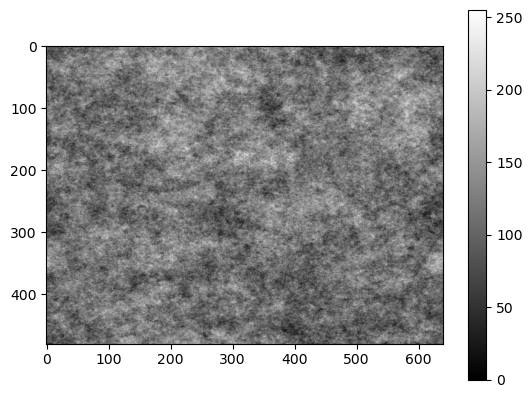

In [3]:
im = np.ones((480,640,3))
onefim = make_onef_ims(np.shape(im))
plt.imshow(onefim,cmap='gray')
plt.colorbar()

## Generate Masks for Each Image (to match size)

In [4]:
import glob
import cv2
imfolder = '/home/gridsan/vdutell/RosenholtzLab_shared/cocop_stims'
imlist = glob.glob(f'{imfolder}/*.jpg', recursive=False)
len(imlist)

44

In [5]:
masklist = []
for impath in imlist:
    im = cv2.imread(impath)
    imnum = impath.split('/')[-1].replace('.jpg','')
    noisemask = make_onef_ims(im.shape)
    masklist.append(noisemask)
    savepath = f'/home/gridsan/groups/RosenholtzLab/cocop_stims/noise_masks/{imnum}_noisemask.png'
    cv2.imwrite(savepath,noisemask)
    #print(noisemask.shape)
    #plt.imshow(noisemask)
    #plt.title(imnum)
    #plt.show()

(213, 320)
(213, 320)
(240, 320)
(240, 320)
(213, 320)
(165, 250)
(213, 320)
(212, 320)
(240, 320)
(240, 320)
(213, 320)
(213, 320)
(213, 320)
(213, 320)
(213, 320)
(240, 320)
(213, 320)
(213, 320)
(187, 250)
(213, 320)
(245, 320)
(166, 250)
(271, 320)
(240, 320)
(213, 320)
(212, 320)
(214, 320)
(185, 320)
(187, 250)
(213, 320)
(240, 320)
(240, 320)
(213, 320)
(213, 320)
(240, 320)
(240, 320)
(214, 320)
(213, 320)
(240, 320)
(214, 320)
(240, 320)
(227, 320)
(212, 320)
(240, 320)


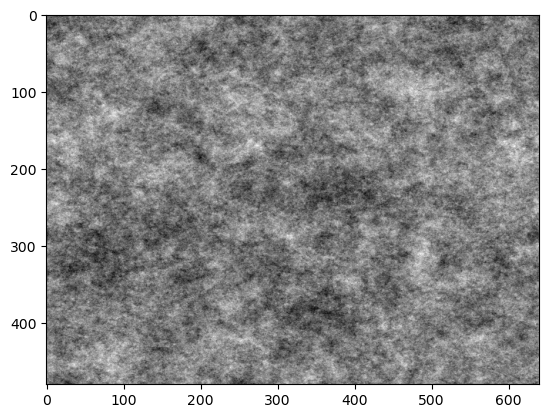

In [6]:
plt.imshow(noisemask,cmap='gray')

## Plot Amplitude Spec of Masks

In [7]:
def spatialft(image, cosine_window=True, rmdc=True):
    """Take the fourier transform of an image (or flow field).
    shift the quadrants around so that low spatial frequencies are in
    the center of the 2D fourier transformed image"""

    #raised cosyne window on image to avoid border artifacts
    (dim1,dim2) = np.shape(image)
    if(cosine_window):
        cosfilter = np.tile(np.hanning(dim2), (dim1,1))*(np.tile(np.hanning(dim1), (dim2,1)).T)
        image = image * cosfilter
    
    # remove DC component
    if(rmdc):
        image =  image - np.mean(image)
    
    ps = np.abs(np.fft.fftshift(np.fft.fft2(image)))**2
    fqs = [np.fft.fftshift(np.fft.fftfreq(np.shape(image)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(image)[1]))]
    return(ps, fqs)

def azimuthalAverage(image, nyquist, center=None, bin_in_log=False):
    """      
    Calculate the azimuthally averaged radial profile. (Intended for 2d Power Spectra)
    image - The 2D image (2d power spectrum)
    nyquist - max frequency value (assume same for x and y)
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)
    num_bins = np.min(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    #ASSUME HERE THAT MAX FREQUENCY IS EQUAL ON BOTH AXES & GRANULARITY VARIES ***
    normalized = ((x-center[0])/np.max(x),(y-center[1])/np.max(y))
    r = np.hypot(normalized[0], normalized[1])
    #don't calculate corners
    keep_circle = np.where(r<=np.max(y))
    r = r[keep_circle]
    image = image[keep_circle]

    # number of bins should be equivalent to the number of bins along the shortest axis of the image.
    if(bin_in_log):
        bin_edges = np.histogram_bin_edges(np.log(r), num_bins)
        bin_edges = np.exp(bin_edges)
    else:
        bin_edges = np.histogram_bin_edges(r, num_bins)
        
    bin_centers = bin_edges[:-1] + ((bin_edges[1]-bin_edges[0])/2)
    bin_centers = bin_centers/np.max(bin_centers)*nyquist

    bin_edges[0] -= 1
    bin_edges[-1] += 1
    
    r_binned = np.digitize(r, bin_edges) - 1
    binmean = np.zeros(num_bins)
    for i in range(num_bins):
        binmean[i] = np.mean(image[np.where(r_binned==(i))])

    return(binmean, bin_centers)

Text(0.5, 1.0, 'Power Spectra of 44 Masks')

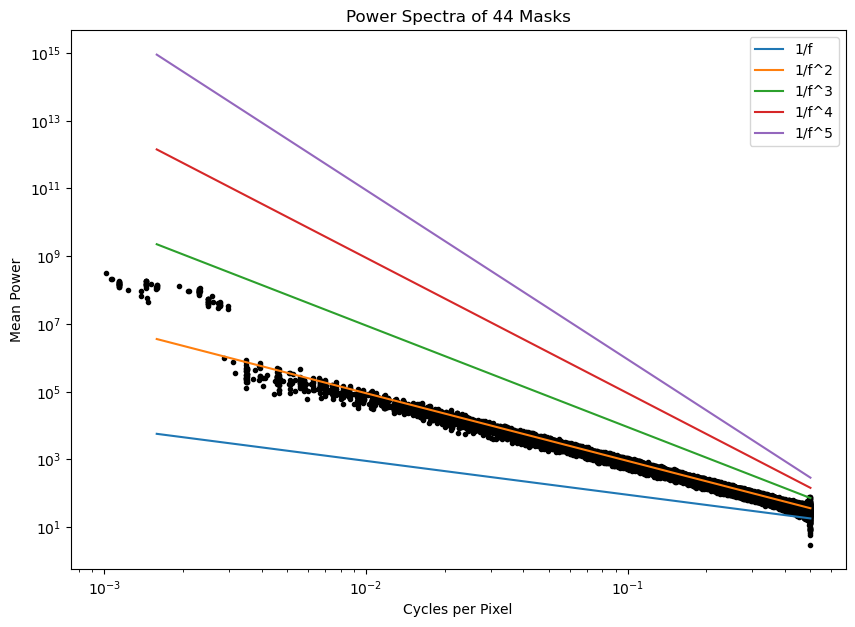

In [8]:
ps_2d_list, fqs_list = map(list, zip(*[spatialft((m.astype(np.float32)/255.)) for m in masklist]))
ps_1d_list, fqs_list = map(list,zip(*[azimuthalAverage(ps,nyquist=0.5) for ps in ps_2d_list]))
#mean_ps_1d, fqs = fim.azimuthalAverage(mean_power_spec, 0.5, bin_in_log=bin_in_log)

plt.figure(figsize=(10,7))
for i in range(len(ps_1d_list)):
    plt.loglog(fqs_list[i], ps_1d_list[i],'.',c='black')

#plt.loglog(fqs_list[2],ps_1d_list[2],'.',c='black')

fqs = fqs_list[1]
ps_1d = ps_1d_list[1]

onef = 1/(fqs) * np.min(ps_1d)
onef2 = 1/(fqs)**2 * np.min(ps_1d)
onef3 = 1/(fqs)**3 * np.min(ps_1d)
onef4 = 1/(fqs)**4 * np.min(ps_1d)
onef5 = 1/(fqs)**5 * np.min(ps_1d)

plt.loglog(fqs, onef, label='1/f')
plt.loglog(fqs, onef2, label='1/f^2')
plt.loglog(fqs, onef3, label='1/f^3')
plt.loglog(fqs, onef4, label='1/f^4')
plt.loglog(fqs, onef5, label='1/f^5')

plt.xlabel('Cycles per Pixel')
plt.ylabel('Mean Power')
plt.legend()
plt.title(f'Power Spectra of {len(fqs_list)} Masks')